In [6]:
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import math 
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Plot track
from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
tu = TrackIO()
tu

In [10]:
TRACK_NAME = "2022_reinvent_champ_cw"
track: Track = tu.load_track(TRACK_NAME)
track

Loaded 113 waypoints


<Axes: >

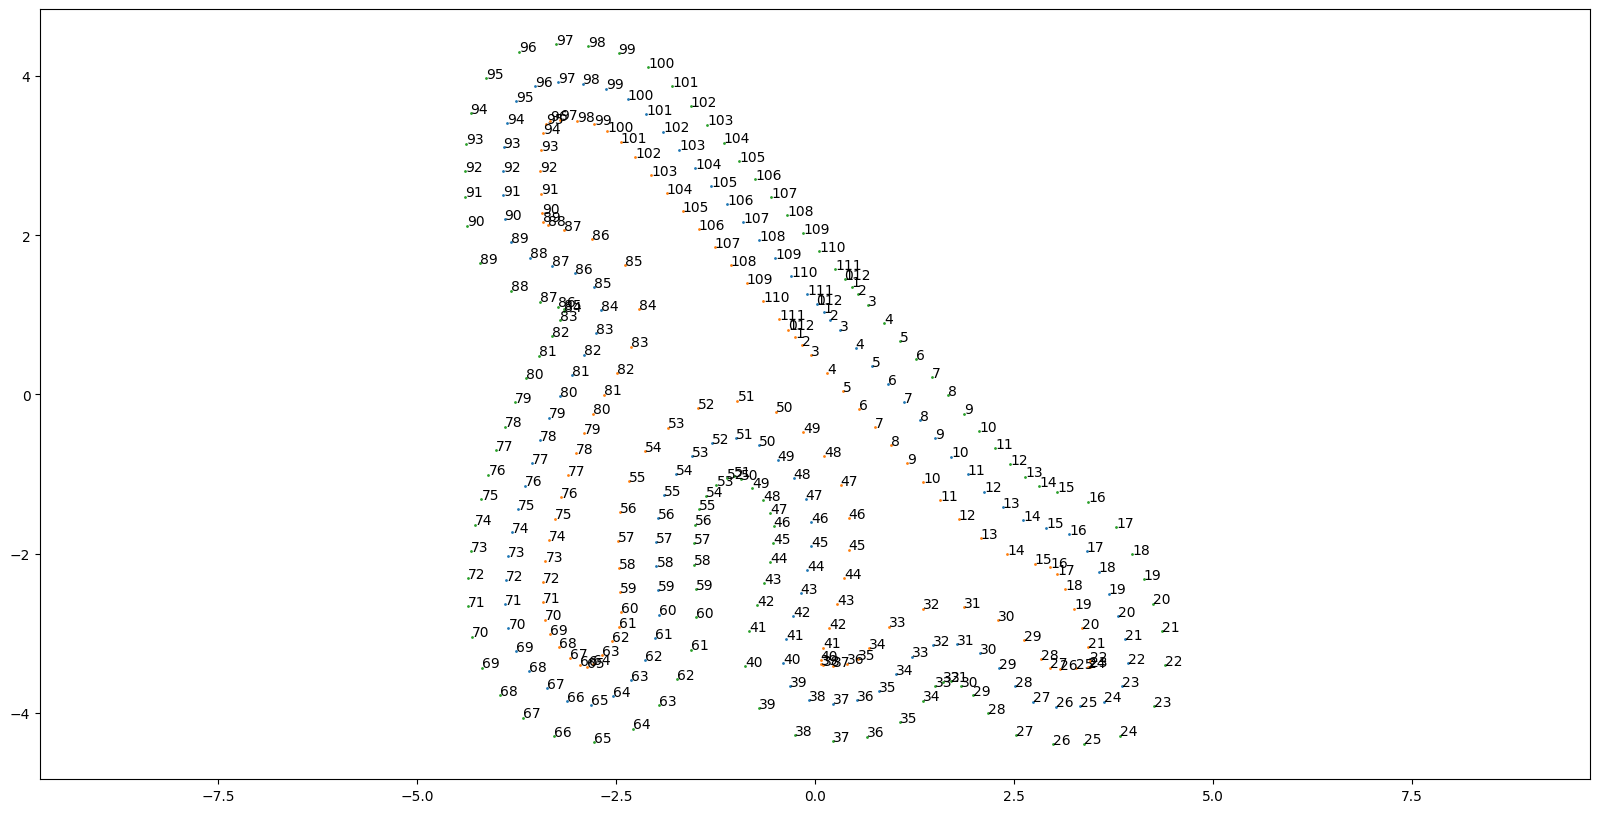

In [11]:
cway = track.center_line
pu.plot_trackpoints(track)

In [18]:
list(range(0, 13)) + list(range(15,17))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16]

In [13]:
def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [14]:
import copy
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS=4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS=1000

def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        #print("%d: %d %d %d %d %d" % (npoints, prevprev, prev, i, nexxt, nexxtnexxt))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        #print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            #print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

In [15]:
print(len(track.center_line))
# start along centerline of track
race_line = copy.deepcopy(track.center_line[:-1])  # Use this for centerline being outer bound
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, track.inner_border, track.outer_border)
    if i % 20 == 0: print("Iteration %d" % i)

113
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260


KeyboardInterrupt: 

In [ ]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                                                                                
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)     

These should be the same:  ((113, 2), (113, 2))
New race line length: 27.14


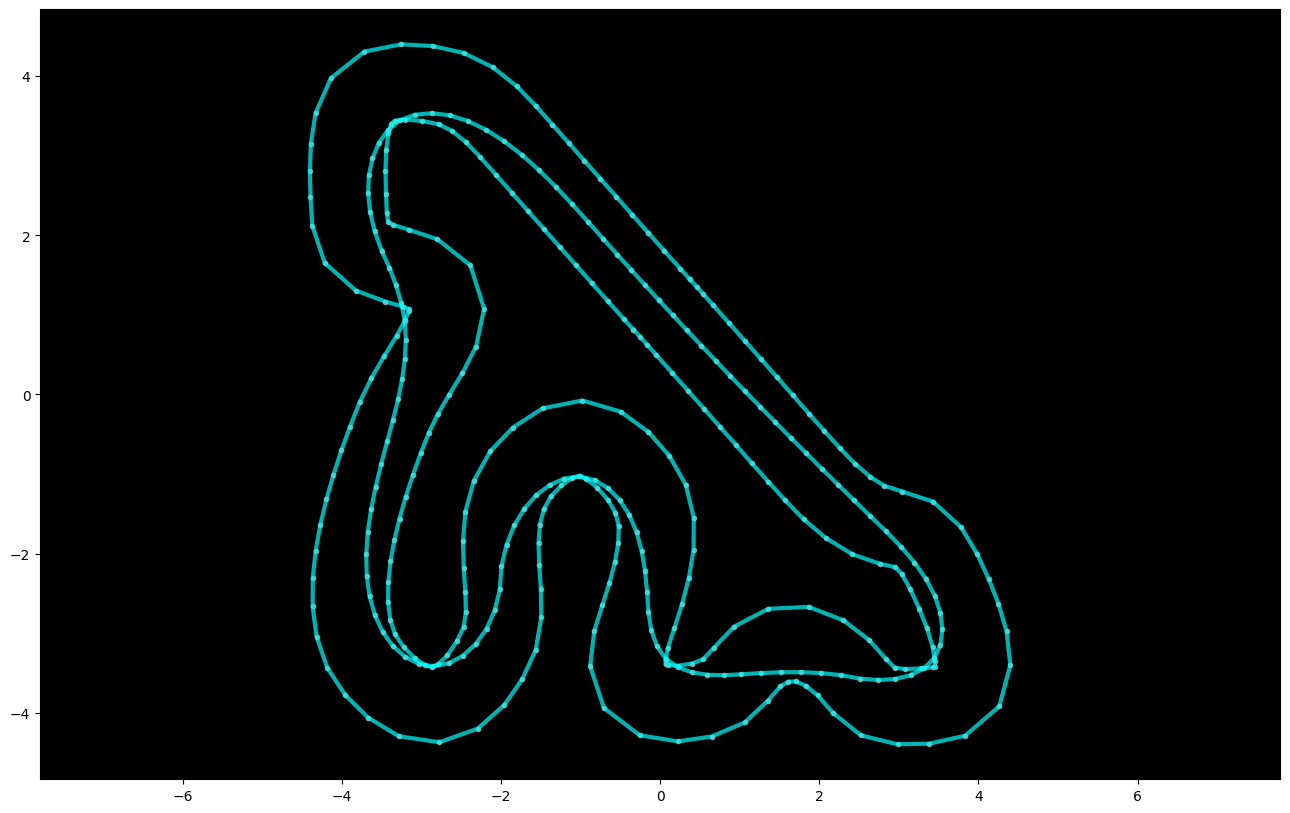

In [ ]:
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (track.center_line.shape, loop_race_line.shape))
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, track.inner_border, track.outer_border)

In [ ]:
from datetime import datetime

now = datetime.now()
prefix = './tracks/%s-%d-%d-%s' % (TRACK_NAME, LINE_ITERATIONS, XI_ITERATIONS, now.strftime('%Y-%m-%d-%H%M%S'))
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(loop_race_line))
    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, loop_race_line)

Writing python code to ./tracks/2022_reinvent_champ_cw-1000-4-2024-08-05-021932.py
Writing numpy binary to ./tracks/2022_reinvent_champ_cw-1000-4-2024-08-05-021932.npy


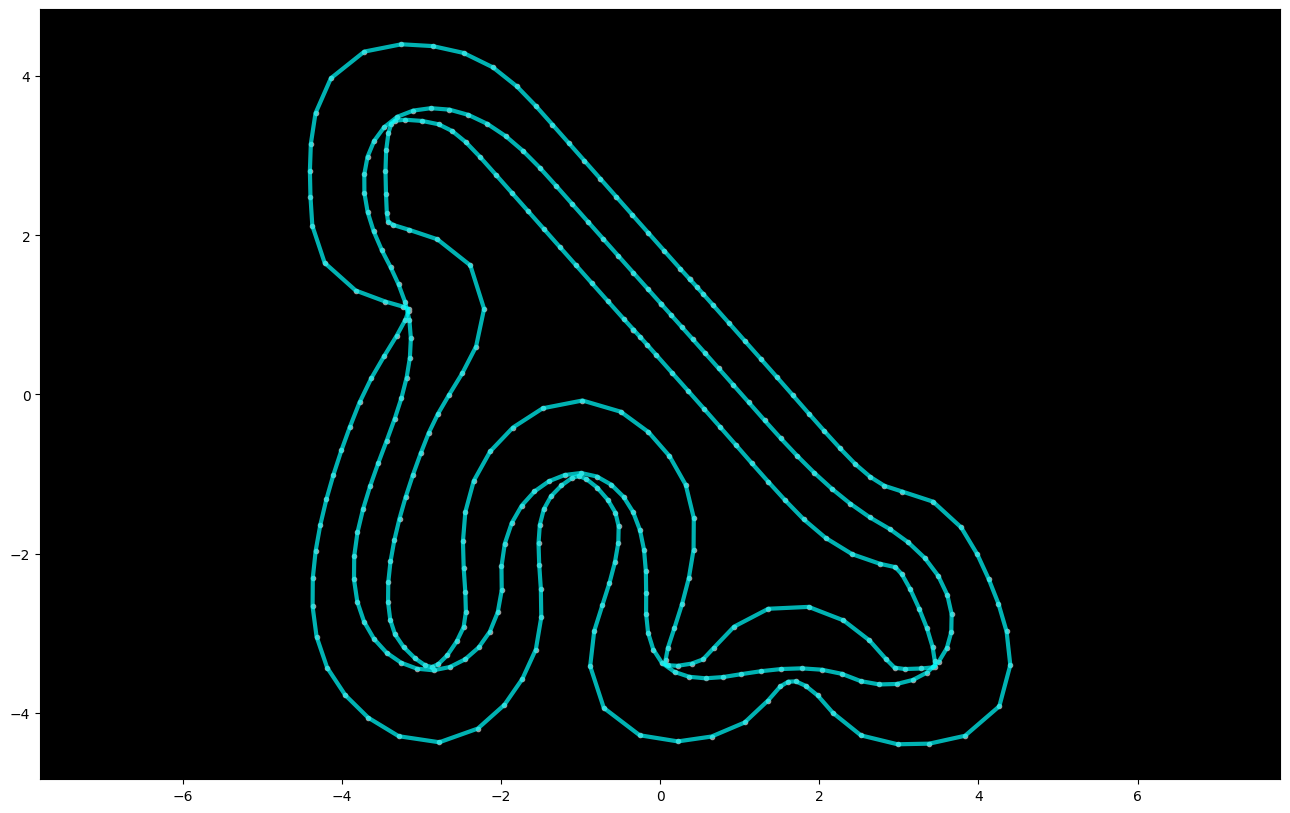

In [ ]:
from numpy import array

fname = './tracks/test.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
deserialized
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, deserialized, track.inner_border, track.outer_border)